In [169]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import math
from tqdm import tqdm
from sklearn.model_selection import  RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics  import f1_score
import numpy as np
from joblib import Parallel, delayed
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [170]:
df = pd.read_excel("../data/data.xls",header= 1)

In [171]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


# Information about the data

- LIMIT_BAL :- Amount of the given credit (NT dollar) it include both the individual consumer credit and his/her family (supplementary credit)
<br>

- SEX :- (1 = male, 2 = female)
<br>

- Education :- (1 = graduate school, 2 = university, 3 = high school, 4 = others)
<br>

- Age :- it include age of the customer in year
<br>

- Pay_0 to Pay_6 :- contain past payment history from April to September 2005
    <br> 
    
    - which month column represent ? :
        - Pay_0 :- September 2005
        - Pay_2 :- August 2005
        - Pay_3 :- July 2005
        - Pay_4 :- June 2005
        - Pay_5 :- May 2005
        - Pay_6 :- April 2005
      
      <br>
      
     - what does value represent from pay_0 to pay_6? :
         - -1 :- pay duly
         - 1 :- payment delay for 1 month
         - 2 :- payment delay for 2 months
         - 3 :- payment delay for 3 months
         - 4 :- payment delay for 4 months
         - 5 :- payment delay for 5 months
         - 6 :- payment delay for 6 months
         - 7 :- payment delay for 7 months
         - 8 :- payment delay for 8 months
<br>

- BILL_AMT1 to BILL_AMT6 :- it contain ammount of bill statement

    - BILL_AMT1 :- it contain amount of bill statement in September 2005
    
    - BILL_AMT2 :- it contain amount of bill statement in August 2005
    
    - BILL_AMT3 :- it contain amount of bill statement in July 2005
    
    - BILL_AMT4 :- it contain amount of bill statement in June 2005
    
    - BILL_AMT5 :- it contain amount of bill statement in May 2005
    
    - BILL_AMT6 :- it contain amount of bill statement in April 2005
    
<br>

- PAY_AMT1 to PAY_AMT6: - it contain amount of previous payment

    - PAY_AMT1:- it contain amount paid in September 2005
    - PAY_AMT2:- it contain amount paid in August 2005
    - PAY_AMT3:- it contain amount paid in July 2005
    - PAY_AMT4:- it contain amount paid in June 2005
    - PAY_AMT5:- it contain amount paid in May 2005
    - PAY_AMT6:- it contain amount paid in April 2005

In [172]:
df.isnull().sum()

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64

Current data don't have any missing values

In [173]:
#get_columns_by_pattern will help us to get column name by the pattern
def get_columns_by_pattern(pattern):
    r = re.compile(pattern)
    return list(filter(r.match, df.columns)) 

In [174]:
def plot_distribution(df_cols,plot_title = None,df = None,cols = 4):
    rows = math.ceil(len(df[df_cols].select_dtypes(exclude = "O").columns) / cols)
    fig, axes = plt.subplots(ncols=cols, nrows=rows,figsize = (15,rows * 5))
    for col,ax in zip(df[df_cols].select_dtypes(exclude = "O").columns,axes.flat):
        fig.suptitle(plot_title, fontsize=15)
        sns.histplot(x = df[col].values,ax = ax,fill = True,kde = True)
        ax.set_title(col)
    sns.despine(bottom=True, trim=True)
    plt.tight_layout(rect=[0, 0.2, 1, 0.99])
    plt.show()
    
    
def plot_countplot(df_cols,univariante= True, bivariante = False,target_col = None, plot_title = None,df = None,cols = None):
    rows = math.ceil(len(df[df_cols].select_dtypes(exclude = "O").columns) / cols)
    fig, axes = plt.subplots(ncols=cols, nrows=rows,figsize = (15,rows * 5))
    for col,ax in zip(df[df_cols].select_dtypes(exclude = "O").columns,axes.flat):
        fig.suptitle(plot_title, fontsize=15)
        if univariante: 
            sns.countplot(x = df[col].values,ax = ax)
        elif bivariante:
            sns.countplot(data = df, x = col,hue = target_col,ax = ax)
        ax.set_title(col)
    sns.despine(bottom=True, trim=True)
    plt.tight_layout(rect=[0, 0.2, 1, 0.99])
    plt.show()

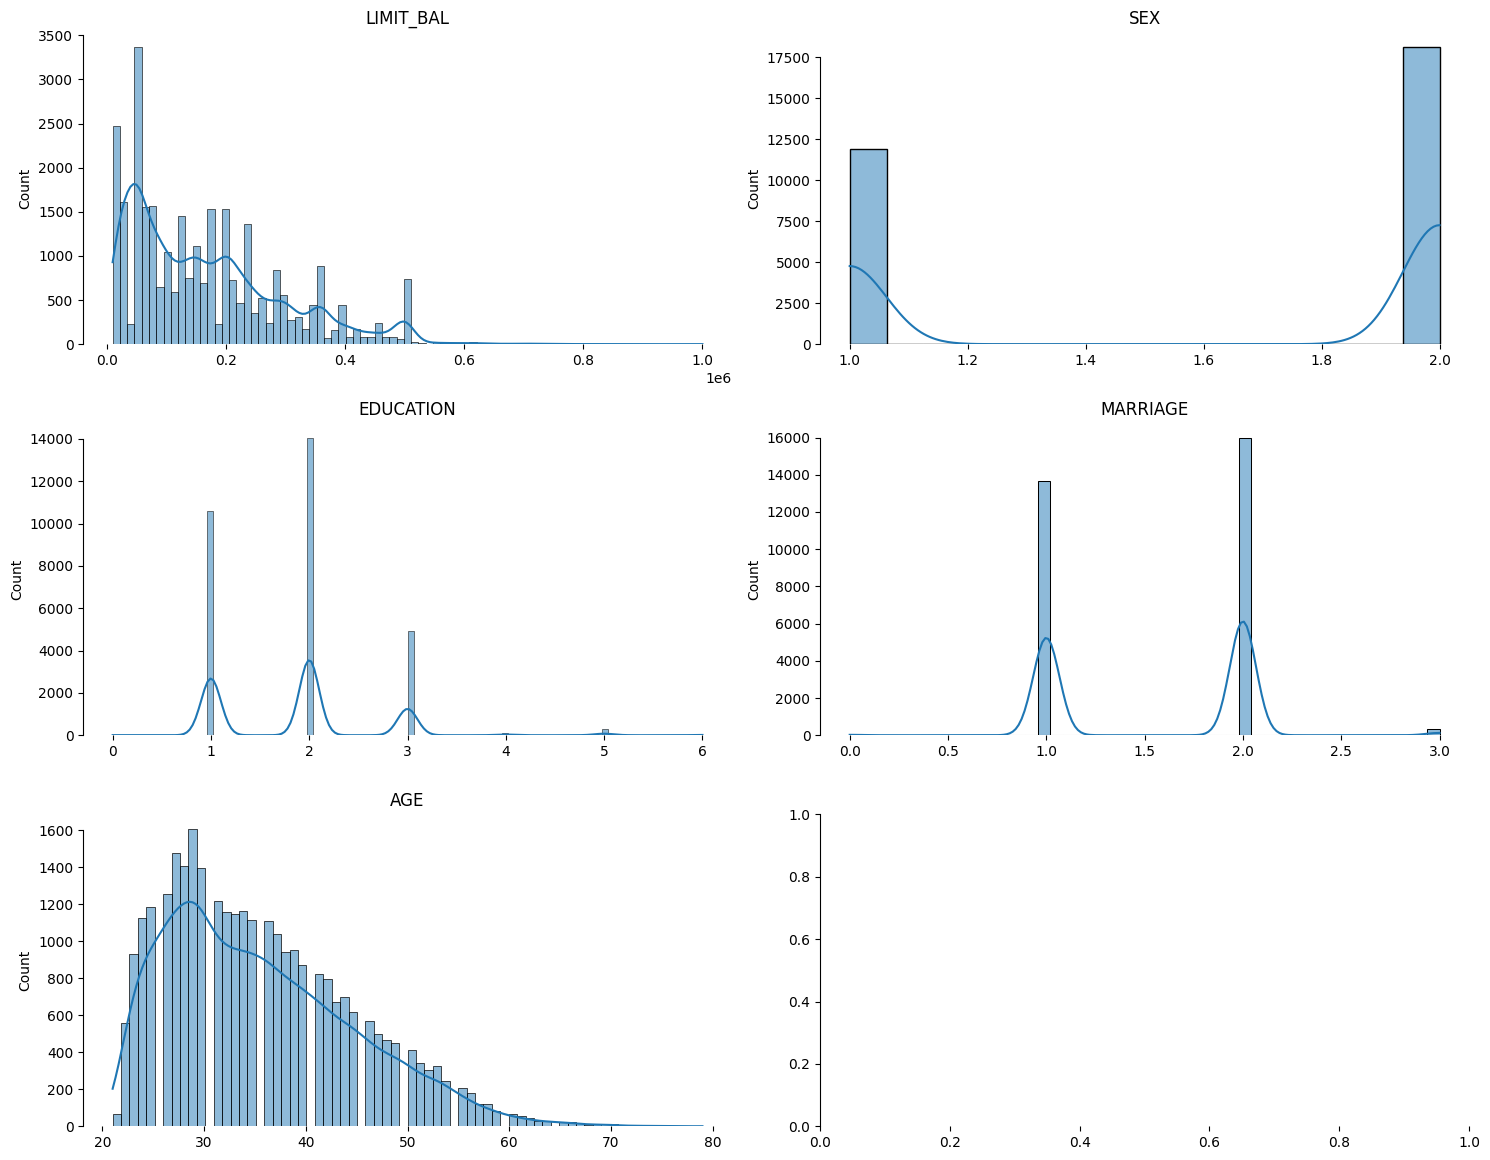

In [175]:
plot_distribution(df_cols = ['LIMIT_BAL','SEX','EDUCATION','MARRIAGE','AGE'],df = df,cols = 2)

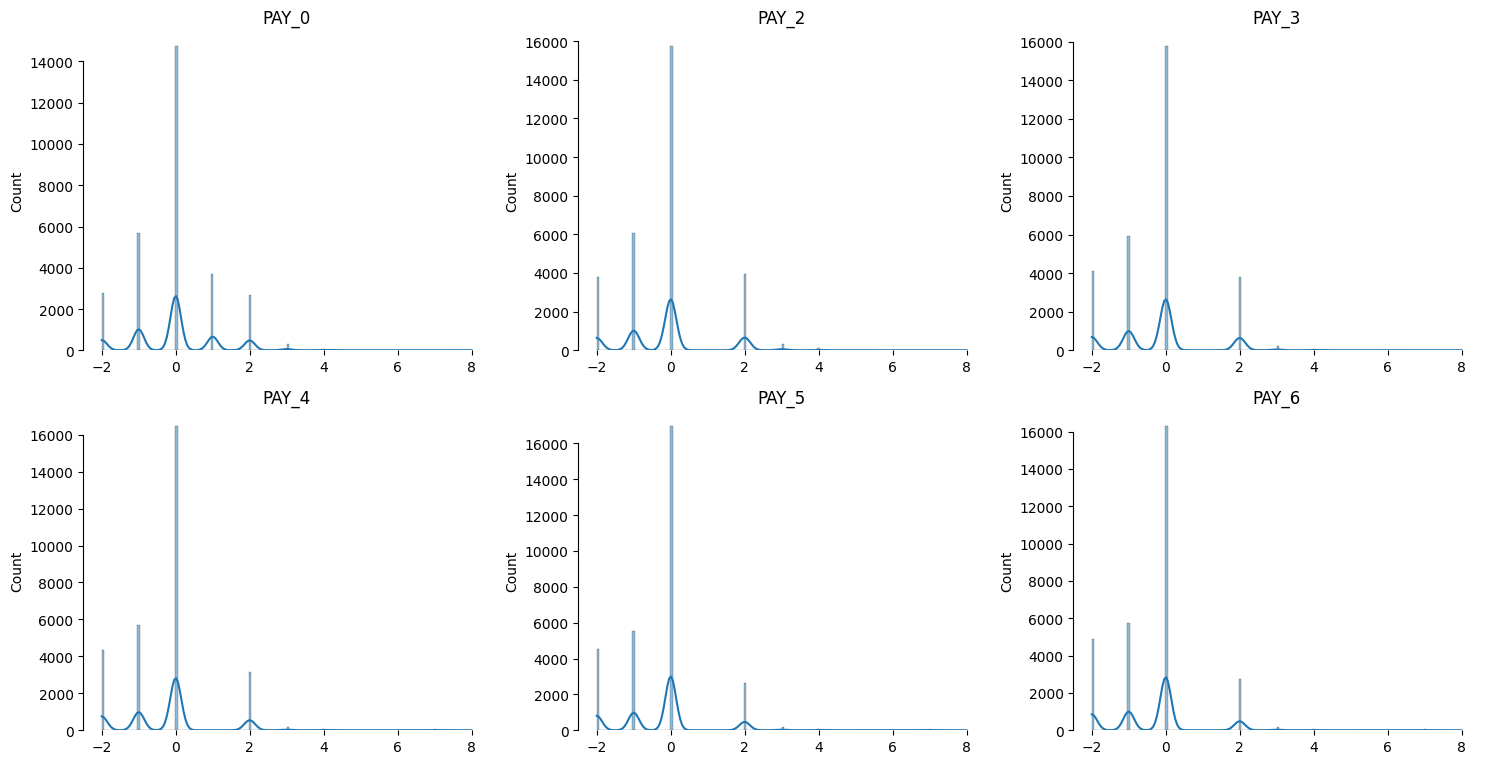

In [176]:
plot_distribution(df_cols = get_columns_by_pattern("PAY_[0-9]"),df = df,cols = 3)

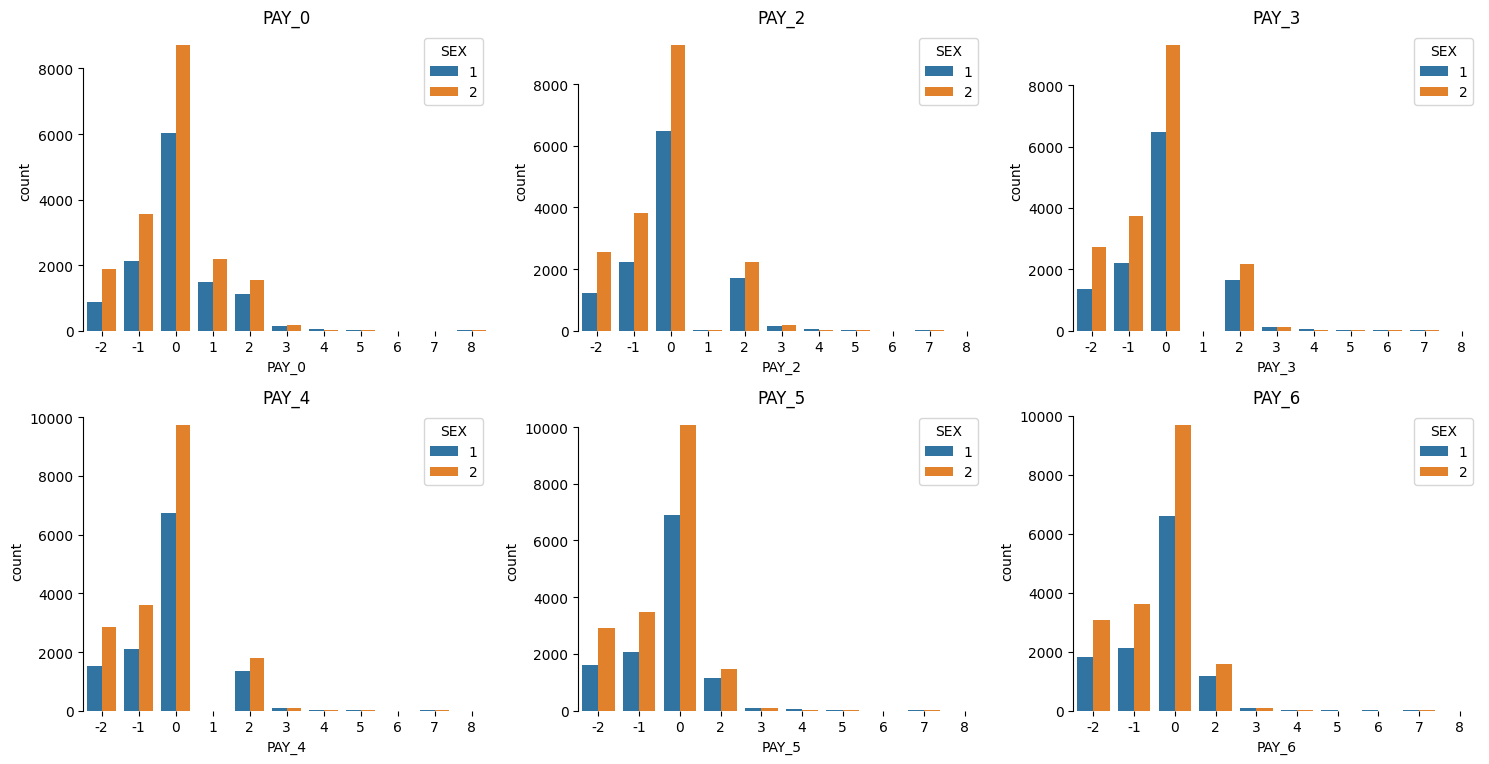

In [177]:
plot_countplot(df_cols = get_columns_by_pattern("PAY_[0-9]"),df = df,bivariante= True,univariante = False,
               target_col= 'SEX',cols = 3)

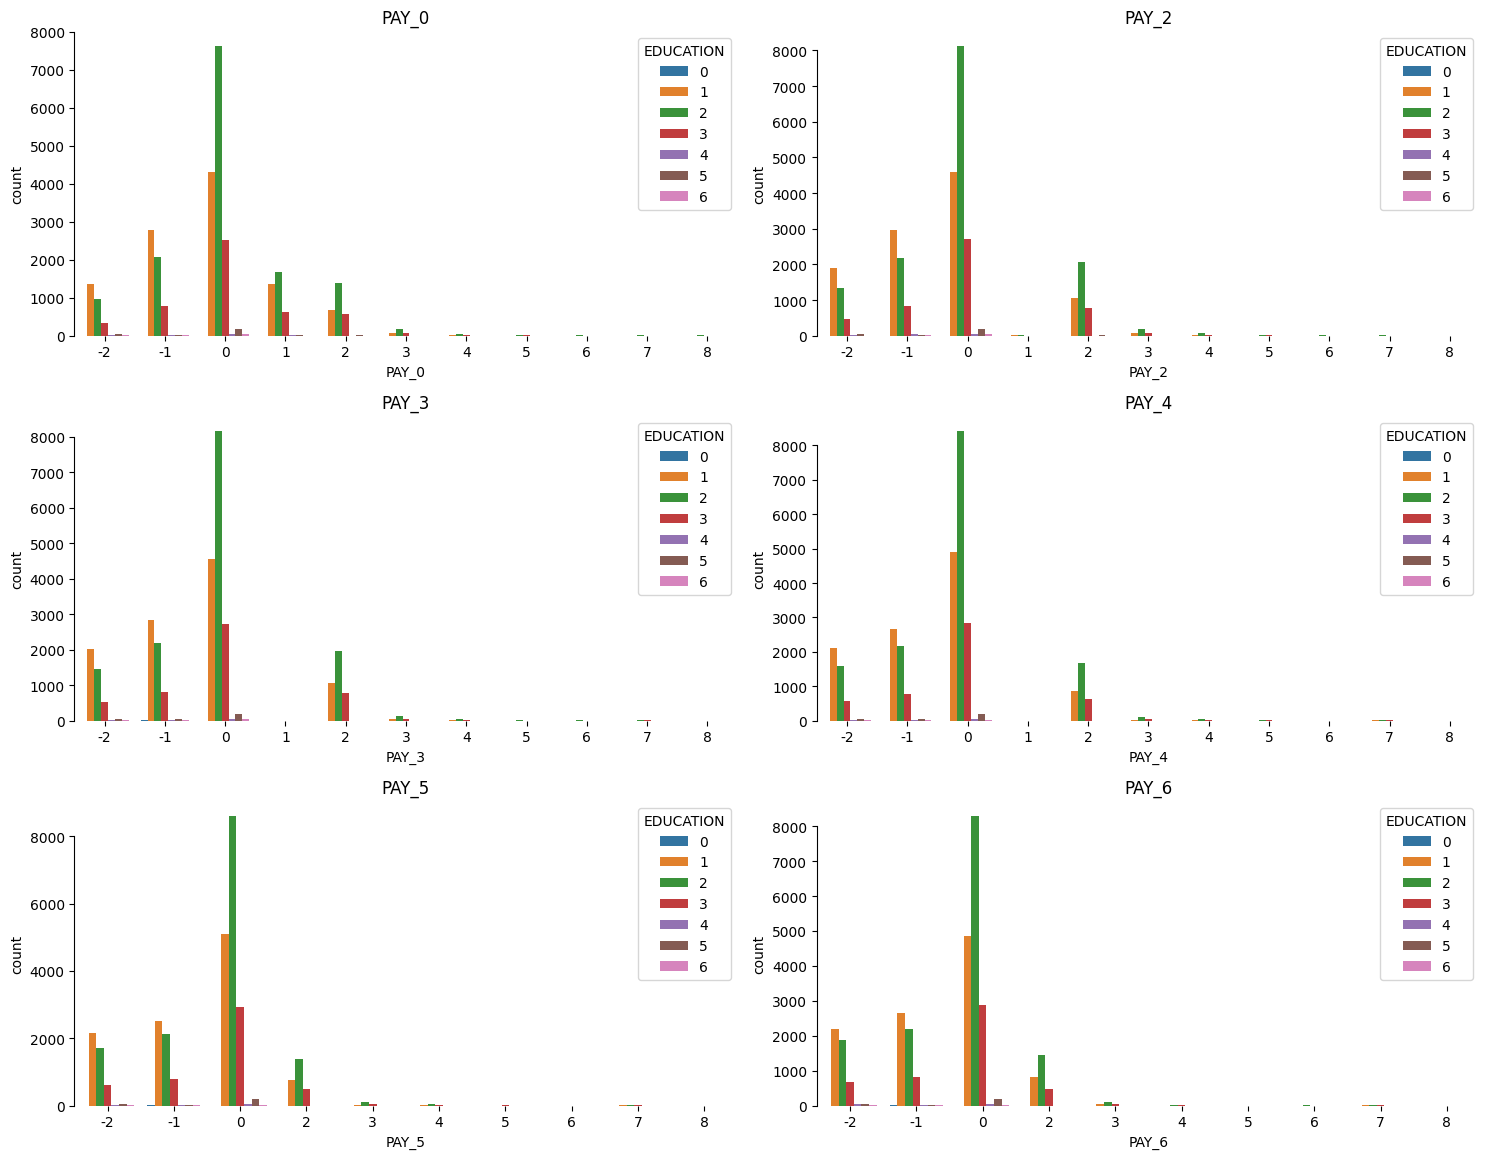

In [178]:
plot_countplot(df_cols = get_columns_by_pattern("PAY_[0-9]"),df = df,bivariante= True,univariante = False,
               target_col= 'EDUCATION',cols = 2)

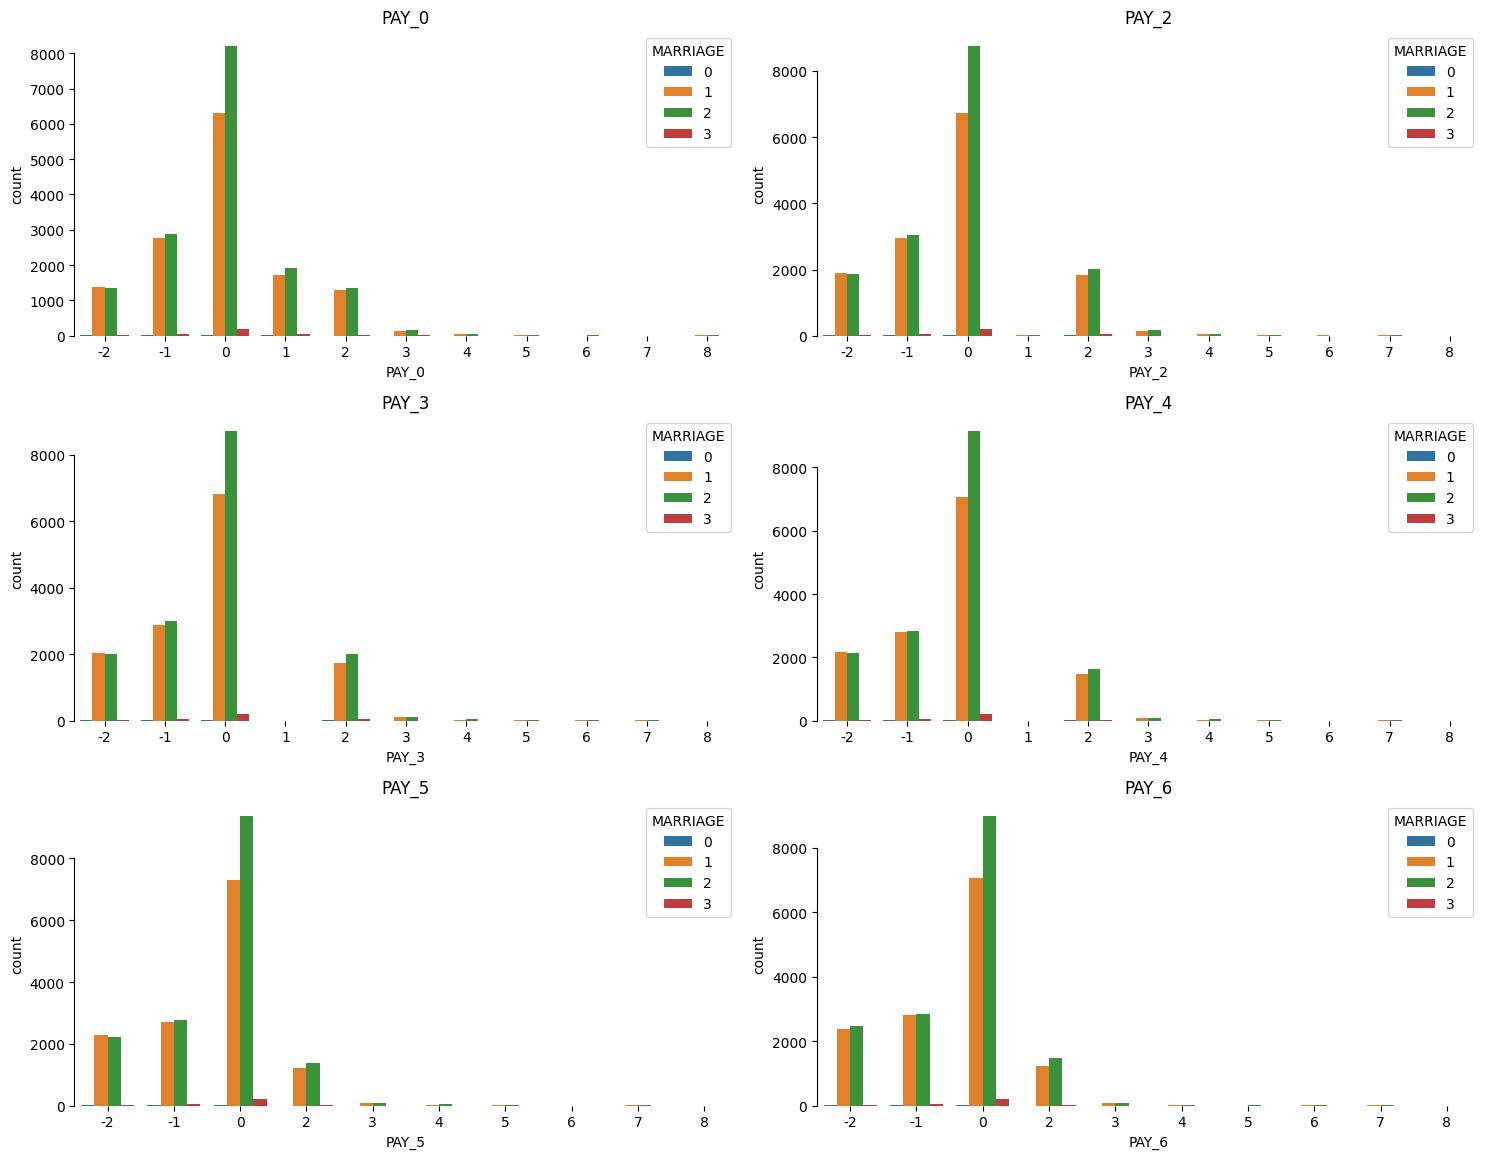

In [179]:
plot_countplot(df_cols = get_columns_by_pattern("PAY_[0-9]"),df = df,bivariante= True,
               univariante = False,target_col= 'MARRIAGE',cols = 2)

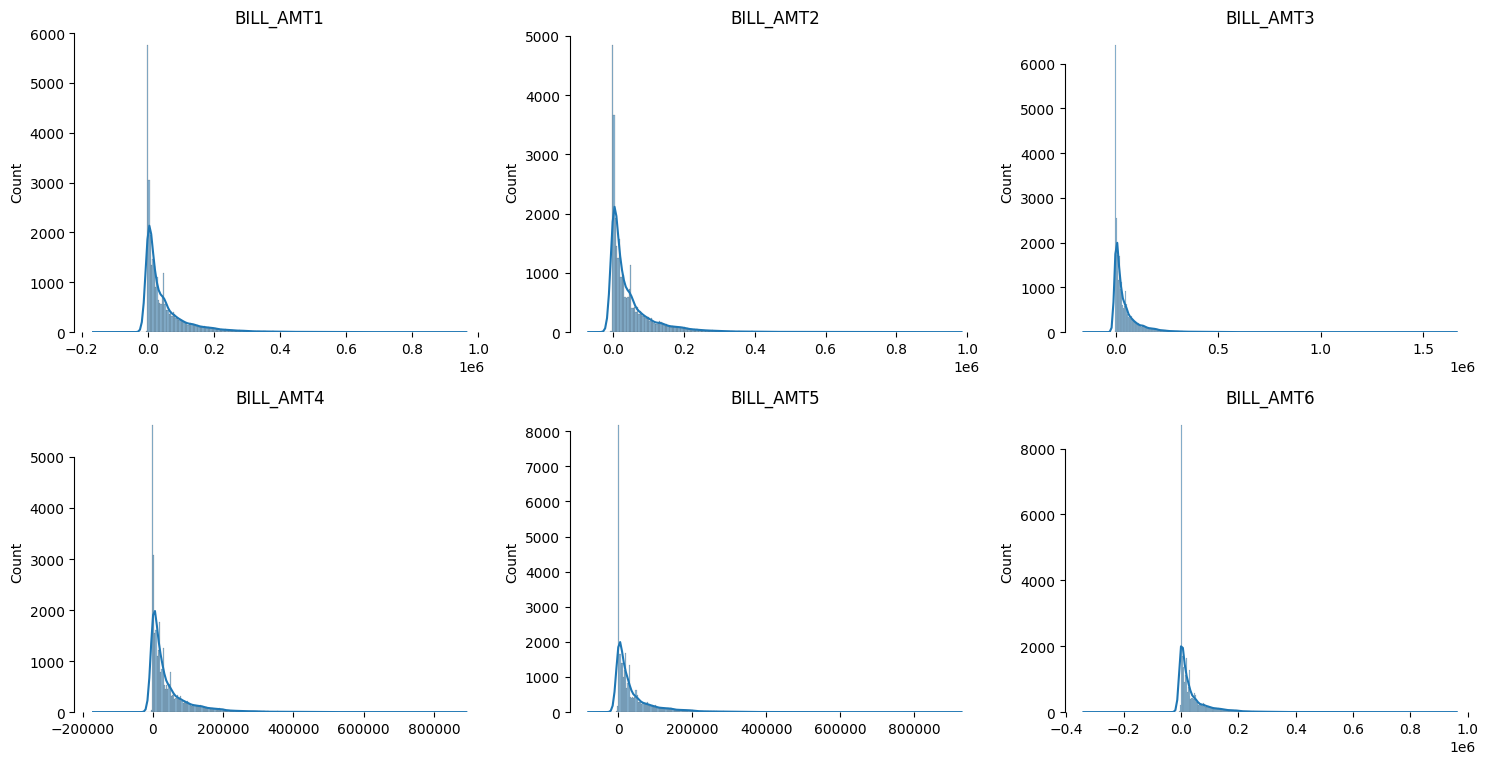

In [180]:
plot_distribution(df_cols = get_columns_by_pattern("BILL_AMT[0-9]"),df = df,cols = 3)

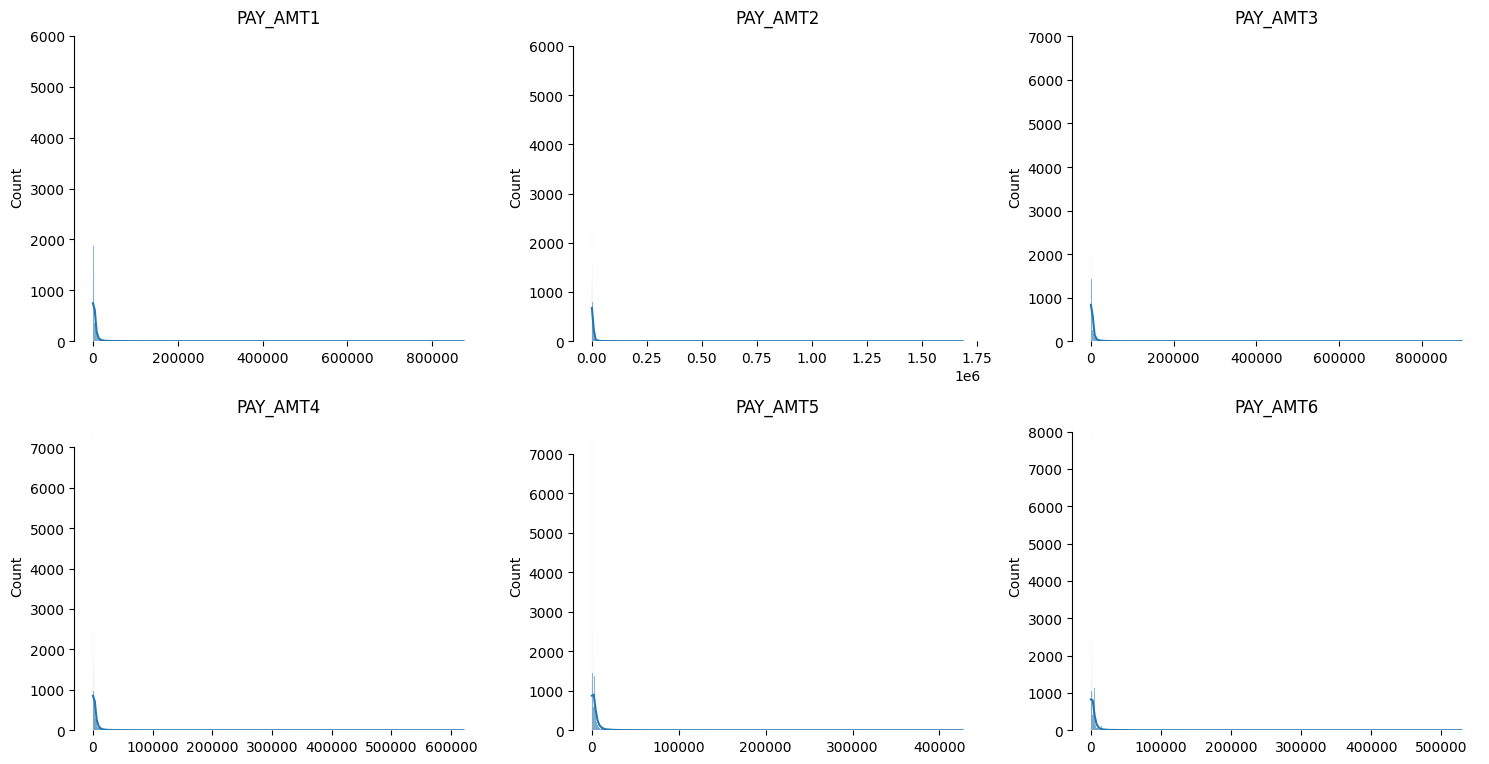

In [181]:
plot_distribution(df_cols = get_columns_by_pattern("PAY_AMT[0-9]"),df = df,cols = 3)

In [182]:
def plot_scatterplot(x ,pattern,df):
    cols = 4
    rows = math.ceil(len( get_columns_by_pattern(pattern)) / cols)
    fig, axes = plt.subplots(ncols=cols, nrows=rows,figsize = (15,rows * 5))
    for col,ax in zip(get_columns_by_pattern(pattern),axes.flat):
        sns.scatterplot(data = df,x = x,y = col,ax = ax)
    sns.despine(bottom=True, trim=True)
    plt.tight_layout(rect=[0, 0.2, 1, 0.99])
    plt.show()

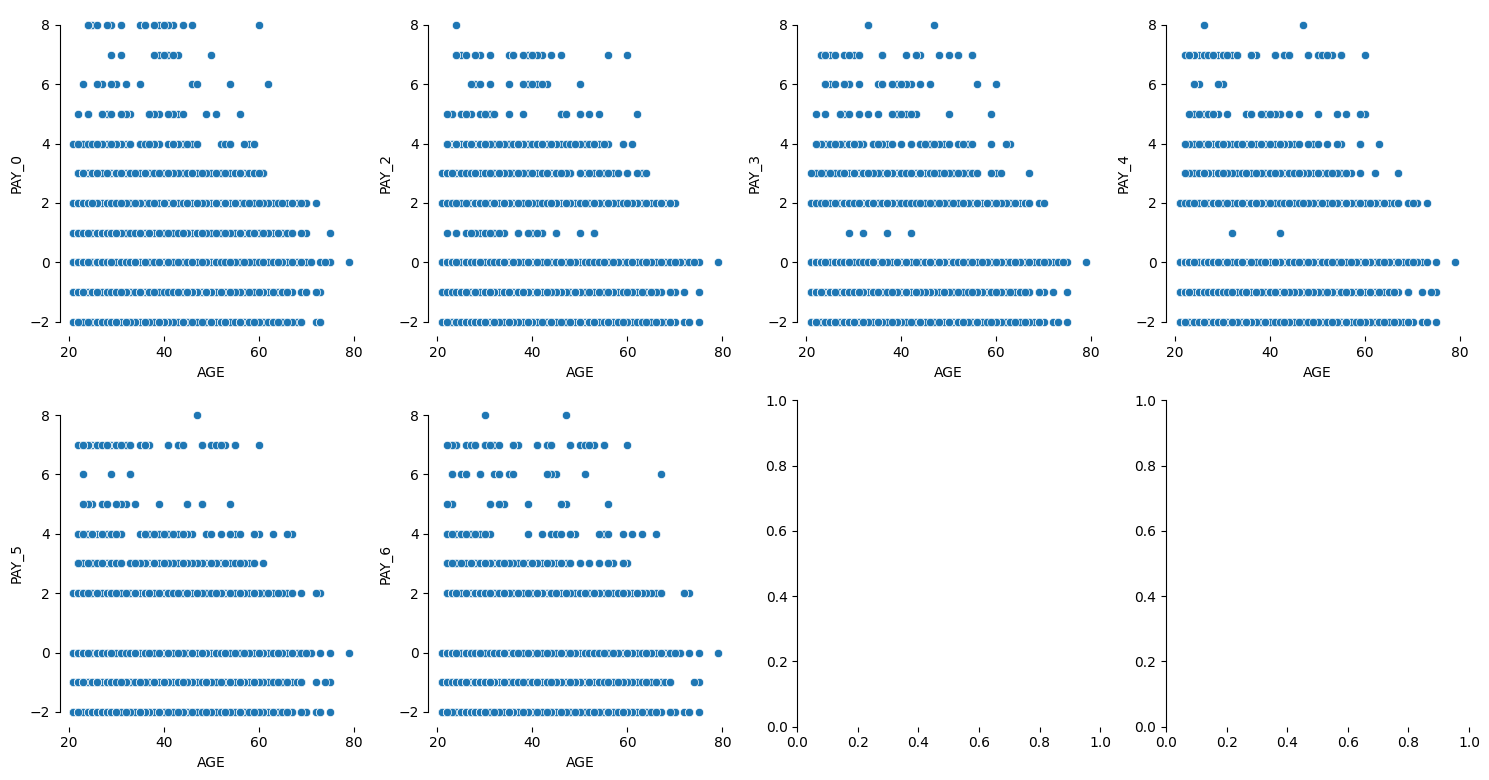

In [183]:
plot_scatterplot('AGE','PAY_[0-9]',df)

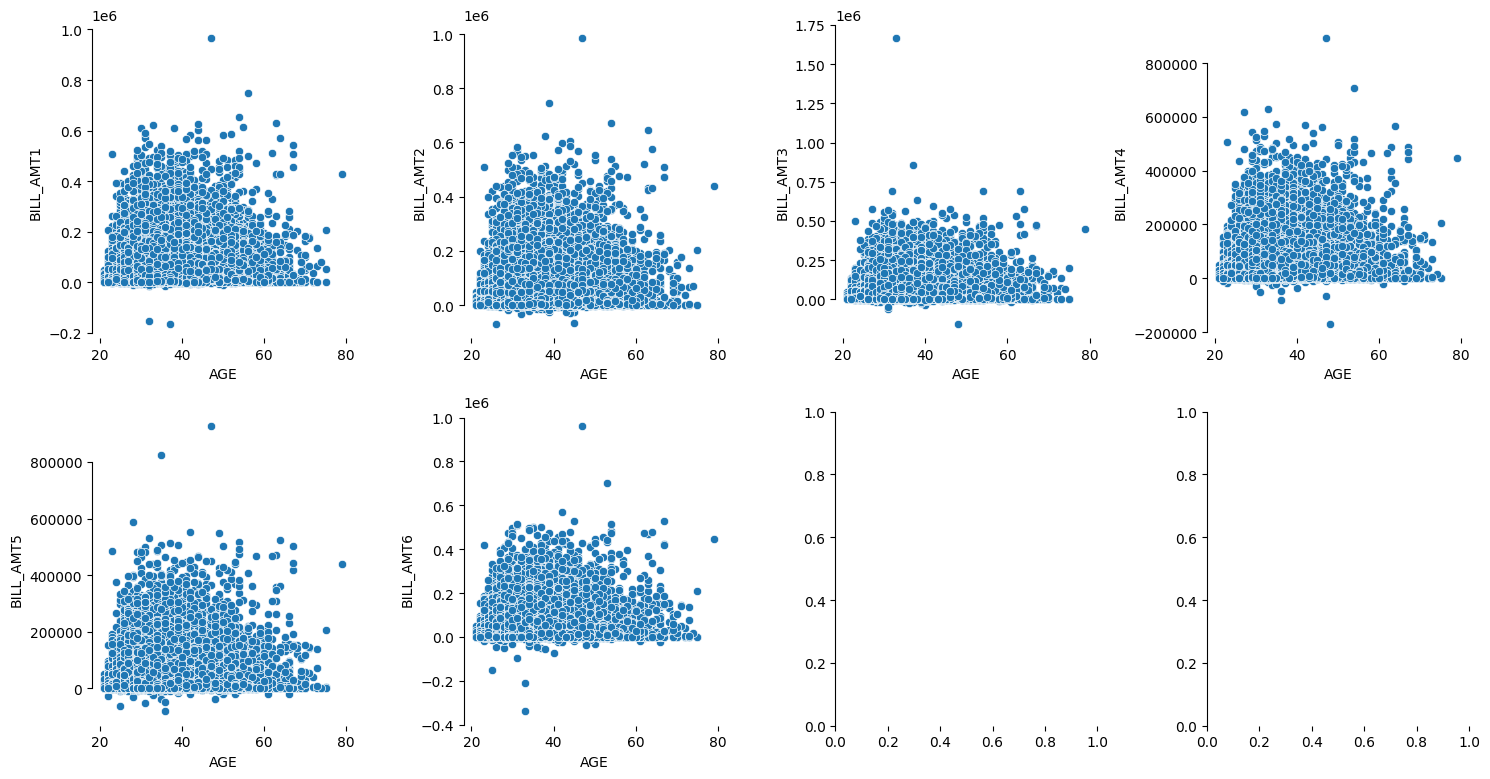

In [184]:
plot_scatterplot('AGE','BILL_AMT[0-9]',df)

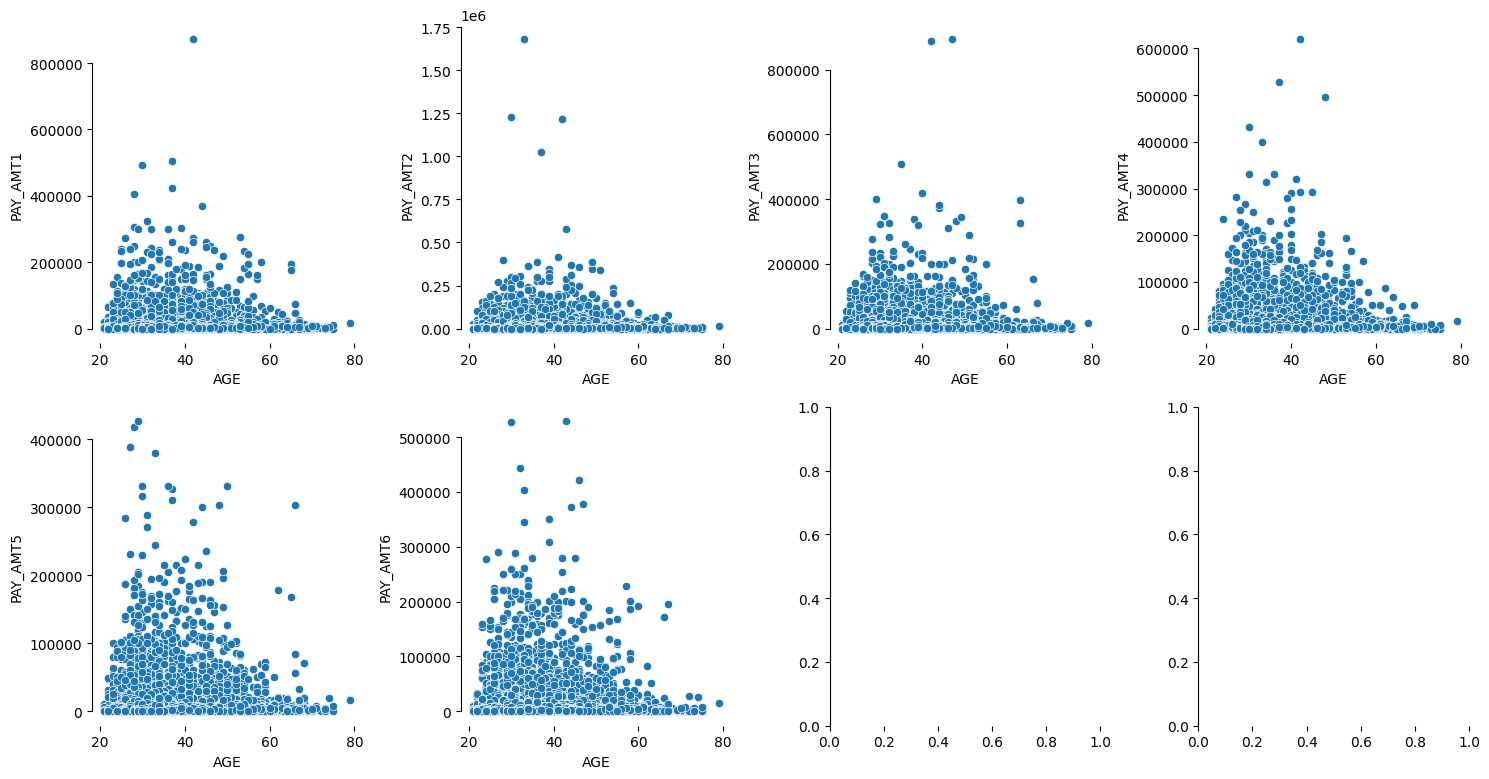

In [185]:
plot_scatterplot('AGE','PAY_AMT[0-9]',df)

<Axes: xlabel='default payment next month', ylabel='Count'>

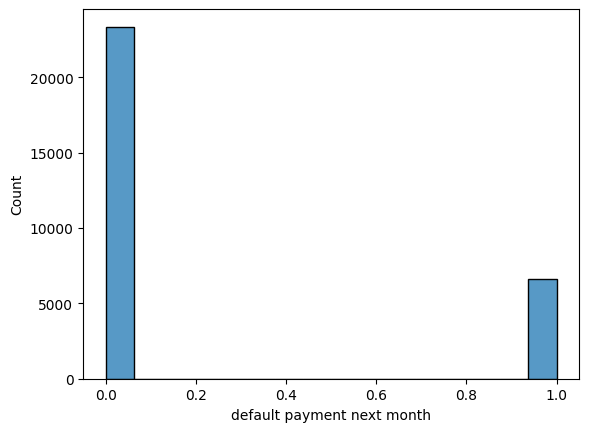

In [186]:
sns.histplot(df['default payment next month'])

default payment next month is an imbalance class we have to fix this before giving data to the model

In [187]:
for col in tqdm(get_columns_by_pattern("PAY_[0-9]")):
    if df[col].min() < 0:
        delay_values = []
        for value in df[col]:
            if value > 0:
                delay_values.append(0)
            else:
                delay_values.append(1)
        
        df["{}_dealy".format(col)] = delay_values
    else:
        df["{}_dealy".format(col)] = -1

100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 124.81it/s]


In [188]:
df['pay_delay_sum'] = df[get_columns_by_pattern("PAY_[0-9]_dealy")].sum(axis = 1)

In [189]:
df['bill_pay_diff_1'] = df['PAY_AMT1'] - df['BILL_AMT1']
df['bill_pay_diff_2'] = df['PAY_AMT2'] - df['BILL_AMT2']
df['bill_pay_diff_3'] = df['PAY_AMT3'] - df['BILL_AMT3'] 
df['bill_pay_diff_4']= df['PAY_AMT4'] - df['BILL_AMT4']
df['bill_pay_diff_5'] = df['PAY_AMT5'] - df['BILL_AMT5']
df['bill_pay_diff_6'] = df['PAY_AMT6'] - df['BILL_AMT6']


In [190]:
df['BILL_AMT_mean'] = df[get_columns_by_pattern("BILL_AMT[0-9]")].mean(axis = 1)
df['PAY_AMT_mean'] = df[get_columns_by_pattern("PAY_AMT[0-9]")].mean(axis = 1)

In [191]:
df

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,PAY_6_dealy,pay_delay_sum,bill_pay_diff_1,bill_pay_diff_2,bill_pay_diff_3,bill_pay_diff_4,bill_pay_diff_5,bill_pay_diff_6,BILL_AMT_mean,PAY_AMT_mean
0,1,20000,2,2,1,24,2,2,-1,-1,...,1,4,-3913,-2413,-689,0,0,0,1284.000000,114.833333
1,2,120000,2,2,2,26,-1,2,0,0,...,0,4,-2682,-725,-1682,-2272,-3455,-1261,2846.166667,833.333333
2,3,90000,2,2,2,34,0,0,0,0,...,1,6,-27721,-12527,-12559,-13331,-13948,-10549,16942.166667,1836.333333
3,4,50000,2,2,1,37,0,0,0,0,...,1,6,-44990,-46214,-48091,-27214,-27890,-28547,38555.666667,1398.000000
4,5,50000,1,2,1,57,-1,0,-1,0,...,1,6,-6617,31011,-25835,-11940,-18457,-18452,18223.166667,9841.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,1,3,1,39,0,0,0,0,...,1,6,-180448,-172815,-203362,-84957,-26237,-14980,120891.500000,7091.666667
29996,29997,150000,1,3,2,43,-1,-1,-1,-1,...,1,6,154,1698,5496,-8850,-5190,0,3530.333333,2415.000000
29997,29998,30000,1,2,2,37,4,3,2,-1,...,1,3,-3565,-3356,19242,-16678,-18582,-16257,11749.333333,5216.666667
29998,29999,80000,1,3,1,41,1,-1,0,0,...,1,5,87545,-74970,-75126,-50848,41109,-47140,44435.166667,24530.166667


In [192]:
df['SEX'] = df['SEX'].replace({1:"male",2:"female"})
df['EDUCATION'] = df['EDUCATION'].replace({1:"graduage_school",2:"university",3:"high_school",4:"others",6:"others",0:"others"})
df['MARRIAGE'] = df['MARRIAGE'].replace({1:"married",2:"single",3:"others",0:"others"})

<!-- - 0 and 6 are unkown category so we have label them as unkown_1_education and unkown_2_education
- 0 is unkown category in marriage so we have label them as unkown_1_marriage -->

In [193]:
df = pd.get_dummies(df,['SEX',"EDUCTION",'MARRIAGE'])

In [194]:
X = df.drop(['ID','default payment next month'],axis = 1)
y = df['default payment next month']

In [195]:
from imblearn.over_sampling import SMOTE

In [196]:
sm = SMOTE(random_state=42)
X_sm,y_sm = sm.fit_resample(X,y)

<Axes: xlabel='default payment next month', ylabel='Count'>

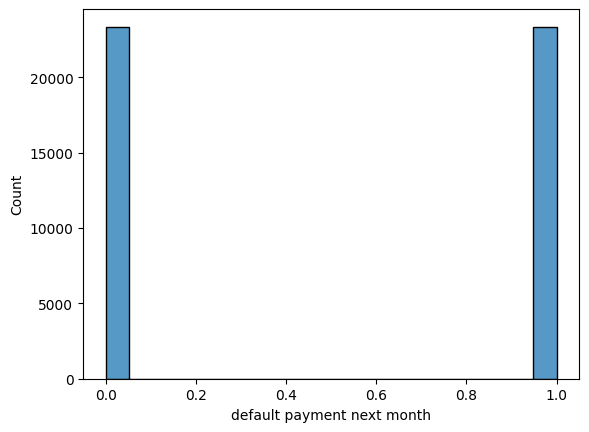

In [197]:
sns.histplot(y_sm)

- we used over_sampling from smote to balance the class

In [198]:
class Trainer:
    def __init__(self,models,X_data,y_data):
        self.models= models
        self.x = X_data
        self.y = y_data
        self.model_performance = {}
        self.model_results= pd.DataFrame()
        
    def train_model(self,model):
        rskf = StratifiedKFold(n_splits= 10,shuffle=True,random_state=42)
        model_f1_score_testing = []
        model_f1_score_training = []
        model_obj = self.models[model]
        split_no = 1
        for train_index, test_index in rskf.split(self.x, self.y):
            X_train,X_test = self.x.iloc[train_index],self.x.iloc[test_index]
            y_train,y_test = self.y[train_index],self.y[test_index]
            model_obj.fit(X_train,y_train)
            model_f1_score_training.append(f1_score(y_train,model_obj.predict(X_train)))
            model_f1_score_testing.append(f1_score(y_test,model_obj.predict(X_test)))
            print(f"Split: {split_no}")
            split_no+=1
        return {'model':model,'f1_training':np.mean(model_f1_score_training),
                                'fl_testing':np.mean(model_f1_score_testing)}
    
    def run(self):
        model_result_dict_list = []
        model_result_dict  = Parallel(n_jobs=4)(delayed(self.train_model)(model) for model in self.models.keys())
        model_result_dict_list.append(model_result_dict)
        return  pd.DataFrame(model_result_dict)
    

In [199]:
models = {
    "Knn": KNeighborsClassifier(),
    "logistic_regression":LogisticRegression(n_jobs = -1),
    "decision Tree":DecisionTreeClassifier(),
    "gradientBoosting":GradientBoostingClassifier(),
    "Adaboost":AdaBoostClassifier(),
    "RandomForest":RandomForestClassifier(n_jobs = -1),
    "Xgboost": XGBClassifier(n_jobs  = -1),
    "Lightgboost": LGBMClassifier(n_jobs = -1),
    "catboost": CatBoostClassifier(verbose = 0)
}

In [200]:
%%time
trainer = Trainer(models,X_sm,y_sm)
model_result = trainer.run()

CPU times: total: 109 ms
Wall time: 5min 30s


In [201]:
model_result

,model,f1_training,fl_testing
0,Knn,0.857370,0.784293
1,logistic_regression,0.465734,0.466495
2,decision Tree,0.999503,0.820556
3,gradientBoosting,0.866865,0.864351
4,Adaboost,0.854912,0.853477
5,RandomForest,0.999494,0.877439
6,Xgboost,0.912630,0.865801
7,Lightgboost,0.880331,0.867023
8,catboost,0.898502,0.866909


In [202]:
xgboost_params = {
    'n_estimators': [10,50,60],
    'max_depth':[10,20,50],
    'max_leaves':[10,20,50],
    'max_bin':[10,20,5],
    'reg_alpha':[0.1,0,0.2],
    'reg_lambda':[0.1,0,0.2],
    'grow_policy':['depthwise','lossguide'],
    'colsample_bytree':[0.1,0.2,0.3],
    'colsample_bylevel':[0.3,0.4,0.5],
    'colsample_bynode':[0.3,0.4,0.5]    
}

In [203]:
xgboost_best = RandomizedSearchCV(XGBClassifier(n_jobs  = -1), xgboost_params,scoring = "f1",n_jobs = -1,n_iter= 5,cv = 10,verbose = 20)
xgboost_best.fit(X_sm,y_sm)

Fitting 10 folds for each of 5 candidates, totalling 50 fits


RandomizedSearchCV(cv=10,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rat...
                                           predictor=None, random_state=None, ...),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'colsample_bylevel': [0.3, 0.4, 0.5],
                                        'colsample_bynode': [0.3, 0.4, 0.5],
                                        'colsample_bytree': [0.1, 0.2, 0.3],
                                        'grow_policy': ['depthwise',
                                                        'lossguide'],
                                        'max_bin': [10, 20, 5],
                                        'max_depth': [10, 20, 50],
                                        'max_leaves': [10, 20, 50],
                                        'n_estimators': [10, 50, 60],
                                        'reg_alpha': [0.1, 0, 0.2],
                                        'reg_lambda': [0.1, 0, 0.2]},
                   scoring='f1', verbose=20)

In [204]:
xgboost_best.best_score_

0.8281400151696291

In [205]:
xgboost_best.best_params_

{'reg_lambda': 0.1,
 'reg_alpha': 0.2,
 'n_estimators': 10,
 'max_leaves': 20,
 'max_depth': 50,
 'max_bin': 5,
 'grow_policy': 'lossguide',
 'colsample_bytree': 0.3,
 'colsample_bynode': 0.5,
 'colsample_bylevel': 0.5}

In [206]:
trainer = Trainer({"xgboost":XGBClassifier(**xgboost_best.best_params_,n_jobs  = -1)},X_sm,y_sm)
model_result = trainer.run()
model_result

,model,f1_training,fl_testing
0,xgboost,0.96372,0.844513
